# 07.3i: Decode Degenerate Structure Tokens

**Goal:** Decode and analyze the 2,211 tokens in the degenerate structure to understand what semantic catastrophe caused them to collapse.

**Structure:**
- **Black holes:** 2,100 tokens that became bfloat16-indistinguishable (collapsed to 13 unique vectors)
- **Kissing cousins:** 111 tokens at ~2× ULP separation (barely distinguishable)

**Questions:**
1. What are these tokens? (strings, Unicode names)
2. Are they semantically related?
3. Language/script distribution?
4. Character types (alphabetic, numeric, punctuation, CJK, etc.)?
5. Why did training collapse them to the same point?

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"  # Using 2.5 since 3-4B might not be available

# Kissing cluster
KISSING_FILE = "kissing_cluster_lat23_lon164.safetensors"
KISSING_KEY = "token_ids"

# Black holes
BLACK_HOLE_MASK_FILE = "black_hole_mask.safetensors"
BLACK_HOLE_MASK_KEY = "mask"

# Gamma matrix (for deduplication)
GAMMA_FILE = "gamma_centered_qwen3_4b_instruct_2507.safetensors"
GAMMA_KEY = "gamma_centered"

# Display settings
MAX_STRING_LENGTH = 40  # Truncate long strings
RANDOM_SEED = 42

## Imports

In [2]:
import torch
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer
import unicodedata
import re
from collections import Counter, defaultdict

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("Imports loaded successfully.")

Imports loaded successfully.


## Load Tokenizer

In [3]:
print(f"Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"  Vocabulary size: {len(tokenizer):,}")
print()

Loading tokenizer: Qwen/Qwen2.5-3B-Instruct
  Vocabulary size: 151,665



## Load Data

In [4]:
data_dir = Path(TENSOR_DIR)

# Load kissing cluster token IDs
print("Loading kissing cluster token IDs...")
kissing_data = load_file(data_dir / KISSING_FILE)
kissing_ids = kissing_data[KISSING_KEY]
n_kissing = len(kissing_ids)
print(f"  Kissing cluster: {n_kissing} tokens")
print()

# Load black hole mask
print("Loading black hole mask...")
bh_data = load_file(data_dir / BLACK_HOLE_MASK_FILE)
black_hole_mask = bh_data[BLACK_HOLE_MASK_KEY]
n_black_holes = black_hole_mask.sum().item()
black_hole_ids = torch.where(black_hole_mask)[0]
print(f"  Black holes: {n_black_holes:,} tokens")
print()

# Load gamma matrix for deduplication
print("Loading gamma matrix...")
gamma_data = load_file(data_dir / GAMMA_FILE)
gamma = gamma_data[GAMMA_KEY]
print(f"  Shape: {gamma.shape}")
print()

Loading kissing cluster token IDs...
  Kissing cluster: 111 tokens

Loading black hole mask...
  Black holes: 2,100 tokens

Loading gamma matrix...
  Shape: torch.Size([151936, 2560])



## Deduplicate Black Holes

In [5]:
print("Deduplicating black hole vectors...")
black_hole_vectors = gamma[black_hole_mask]
unique_bh_vectors, inverse_indices = torch.unique(black_hole_vectors, dim=0, return_inverse=True)
n_unique_bh = len(unique_bh_vectors)

print(f"  Unique black hole vectors: {n_unique_bh}")
print(f"  Total black hole tokens:   {n_black_holes:,}")
print(f"  Degeneracy (avg):          {n_black_holes / n_unique_bh:.1f} tokens per unique vector")
print()

# Map each token ID to its unique vector index
# inverse_indices[i] tells you which unique vector black_hole_ids[i] maps to
bh_to_unique = inverse_indices.cpu().numpy()
bh_ids_np = black_hole_ids.cpu().numpy()

print(f"  Created mapping: {len(bh_ids_np):,} token IDs → {n_unique_bh} unique vectors")
print()

Deduplicating black hole vectors...
  Unique black hole vectors: 13
  Total black hole tokens:   2,100
  Degeneracy (avg):          161.5 tokens per unique vector

  Created mapping: 2,100 token IDs → 13 unique vectors



## Utility Functions

In [6]:
def get_token_string(token_id, tokenizer, max_length=MAX_STRING_LENGTH):
    """Decode token ID to string, truncate if needed."""
    try:
        s = tokenizer.decode([token_id])
        if len(s) > max_length:
            return s[:max_length-3] + "..."
        return s
    except:
        return "<DECODE_ERROR>"

def get_unicode_name(s):
    """Get Unicode name for single-character string."""
    if len(s) != 1:
        return ""
    try:
        return unicodedata.name(s)
    except:
        return "<NO_NAME>"

def classify_character(s):
    """Classify character type."""
    if len(s) == 0:
        return "empty"
    if len(s) > 1:
        return "multi-char"
    
    c = s[0]
    
    # Unicode category
    cat = unicodedata.category(c)
    
    # Specific classifications
    if cat.startswith('L'):  # Letter
        # Try to detect script
        name = get_unicode_name(s)
        if 'THAI' in name:
            return 'Thai'
        elif 'CJK' in name or 'HIRAGANA' in name or 'KATAKANA' in name:
            return 'CJK'
        elif 'ARABIC' in name:
            return 'Arabic'
        elif 'CYRILLIC' in name:
            return 'Cyrillic'
        elif 'LATIN' in name:
            return 'Latin'
        else:
            return 'Other Letter'
    elif cat.startswith('N'):  # Number
        return 'Number'
    elif cat.startswith('P'):  # Punctuation
        return 'Punctuation'
    elif cat.startswith('S'):  # Symbol
        return 'Symbol'
    elif cat.startswith('Z'):  # Separator (space, etc.)
        return 'Whitespace'
    elif cat.startswith('M'):  # Mark (combining chars)
        return 'Mark'
    elif cat.startswith('C'):  # Control/Other
        return 'Control'
    else:
        return cat

print("Utility functions defined.")

Utility functions defined.


## Decode Black Holes

In [7]:
print("Decoding black hole tokens...")
print()

# Group tokens by unique vector
unique_groups = defaultdict(list)
for i, token_id in enumerate(bh_ids_np):
    unique_idx = bh_to_unique[i]
    unique_groups[unique_idx].append(token_id)

# Decode each group
bh_decoded = []
for unique_idx in range(n_unique_bh):
    token_ids = unique_groups[unique_idx]
    degeneracy = len(token_ids)
    
    # Decode all tokens in this group
    for token_id in token_ids:
        s = get_token_string(token_id, tokenizer)
        unicode_name = get_unicode_name(s)
        char_type = classify_character(s)
        
        bh_decoded.append({
            'unique_idx': unique_idx,
            'token_id': token_id,
            'string': s,
            'length': len(s),
            'unicode_name': unicode_name,
            'type': char_type,
            'degeneracy': degeneracy
        })

print(f"Decoded {len(bh_decoded):,} black hole tokens.")
print()

Decoding black hole tokens...

Decoded 2,100 black hole tokens.



## Decode Kissing Cousins

In [8]:
print("Decoding kissing cousin tokens...")
print()

kc_decoded = []
for token_id in kissing_ids.cpu().numpy():
    s = get_token_string(token_id, tokenizer)
    unicode_name = get_unicode_name(s)
    char_type = classify_character(s)
    
    kc_decoded.append({
        'token_id': token_id,
        'string': s,
        'length': len(s),
        'unicode_name': unicode_name,
        'type': char_type
    })

print(f"Decoded {len(kc_decoded)} kissing cousin tokens.")
print()

Decoding kissing cousin tokens...

Decoded 111 kissing cousin tokens.



## Black Holes: Summary by Unique Vector

In [9]:
print("="*100)
print("BLACK HOLES: Summary by Unique Vector")
print("="*100)
print()

for unique_idx in range(n_unique_bh):
    group_tokens = [t for t in bh_decoded if t['unique_idx'] == unique_idx]
    degeneracy = len(group_tokens)
    
    print(f"Unique Vector #{unique_idx} (degeneracy: {degeneracy} tokens)")
    print("-" * 100)
    
    # Type distribution
    types = Counter([t['type'] for t in group_tokens])
    print(f"  Character types: {dict(types)}")
    
    # Show first 10 tokens
    print(f"  First {min(10, degeneracy)} tokens:")
    for i, t in enumerate(group_tokens[:10]):
        token_id = t['token_id']
        s = t['string']
        unicode_name = t['unicode_name']
        char_type = t['type']
        
        # Format string for display (escape special chars)
        s_display = repr(s)[1:-1]  # Remove quotes from repr
        if len(s_display) > 30:
            s_display = s_display[:27] + "..."
        
        unicode_display = unicode_name if unicode_name else ""
        if len(unicode_display) > 40:
            unicode_display = unicode_display[:37] + "..."
        
        print(f"    [{token_id:6d}] {s_display:30s} {char_type:15s} {unicode_display}")
    
    if degeneracy > 10:
        print(f"    ... and {degeneracy - 10} more tokens")
    
    print()

print()

BLACK HOLES: Summary by Unique Vector

Unique Vector #0 (degeneracy: 10 tokens)
----------------------------------------------------------------------------------------------------
  Character types: {'multi-char': 10}
  First 10 tokens:
    [119349] 珊󠄁                             multi-char      
    [125087] ช่วย                           multi-char      
    [126630] จัง                            multi-char      
    [137856] กรี                            multi-char      
    [138110] ผู้ใช้                         multi-char      
    [139345] ภาษี                           multi-char      
    [142061]  อย่างไร                       multi-char      
    [143029] เชื่อมต่อ                      multi-char      
    [143036]  مساءً                         multi-char      
    [143048] ศิลปะ                          multi-char      

Unique Vector #1 (degeneracy: 4 tokens)
----------------------------------------------------------------------------------------------------
  Characte

## Kissing Cousins: Full List

In [10]:
print("="*100)
print("KISSING COUSINS: All 111 Tokens")
print("="*100)
print()

# Sort by type for easier reading
kc_sorted = sorted(kc_decoded, key=lambda x: (x['type'], x['token_id']))

for t in kc_sorted:
    token_id = t['token_id']
    s = t['string']
    unicode_name = t['unicode_name']
    char_type = t['type']
    
    # Format string for display
    s_display = repr(s)[1:-1]
    if len(s_display) > 30:
        s_display = s_display[:27] + "..."
    
    unicode_display = unicode_name if unicode_name else ""
    if len(unicode_display) > 50:
        unicode_display = unicode_display[:47] + "..."
    
    print(f"[{token_id:6d}] {s_display:30s} {char_type:15s} {unicode_display}")

print()

KISSING COUSINS: All 111 Tokens

[146175] 利                              CJK             CJK COMPATIBILITY IDEOGRAPH-F9DD
[147243] 念                              CJK             CJK COMPATIBILITY IDEOGRAPH-F9A3
[147507] 復                              CJK             CJK COMPATIBILITY IDEOGRAPH-F966
[147712] 留                              CJK             CJK COMPATIBILITY IDEOGRAPH-F9CD
[148458] 劣                              CJK             CJK COMPATIBILITY IDEOGRAPH-F99D
[148826] 視                              CJK             CJK COMPATIBILITY IDEOGRAPH-FA61
[148830] 晴                              CJK             CJK COMPATIBILITY IDEOGRAPH-FA12
[148932] 魯                              CJK             CJK COMPATIBILITY IDEOGRAPH-F939
[149121] 漏                              CJK             CJK COMPATIBILITY IDEOGRAPH-F94E
[149811] 累                              CJK             CJK COMPATIBILITY IDEOGRAPH-F94F
[149822] 易                              CJK             CJK COMPATIBILITY IDE

## Character Type Analysis

In [11]:
print("Character type distribution:")
print()

# Black holes
bh_types = Counter([t['type'] for t in bh_decoded])
print("Black holes (2,100 tokens):")
for char_type, count in bh_types.most_common():
    pct = 100 * count / len(bh_decoded)
    print(f"  {char_type:20s}: {count:5d} ({pct:5.1f}%)")
print()

# Kissing cousins
kc_types = Counter([t['type'] for t in kc_decoded])
print("Kissing cousins (111 tokens):")
for char_type, count in kc_types.most_common():
    pct = 100 * count / len(kc_decoded)
    print(f"  {char_type:20s}: {count:5d} ({pct:5.1f}%)")
print()

Character type distribution:

Black holes (2,100 tokens):
  multi-char          :  1601 ( 76.2%)
  empty               :   263 ( 12.5%)
  CJK                 :   178 (  8.5%)
  Other Letter        :    37 (  1.8%)
  Symbol              :    17 (  0.8%)
  Punctuation         :     4 (  0.2%)

Kissing cousins (111 tokens):
  multi-char          :    89 ( 80.2%)
  CJK                 :    16 ( 14.4%)
  empty               :     4 (  3.6%)
  Symbol              :     1 (  0.9%)
  Other Letter        :     1 (  0.9%)



## Visualizations

### Character Type Distribution

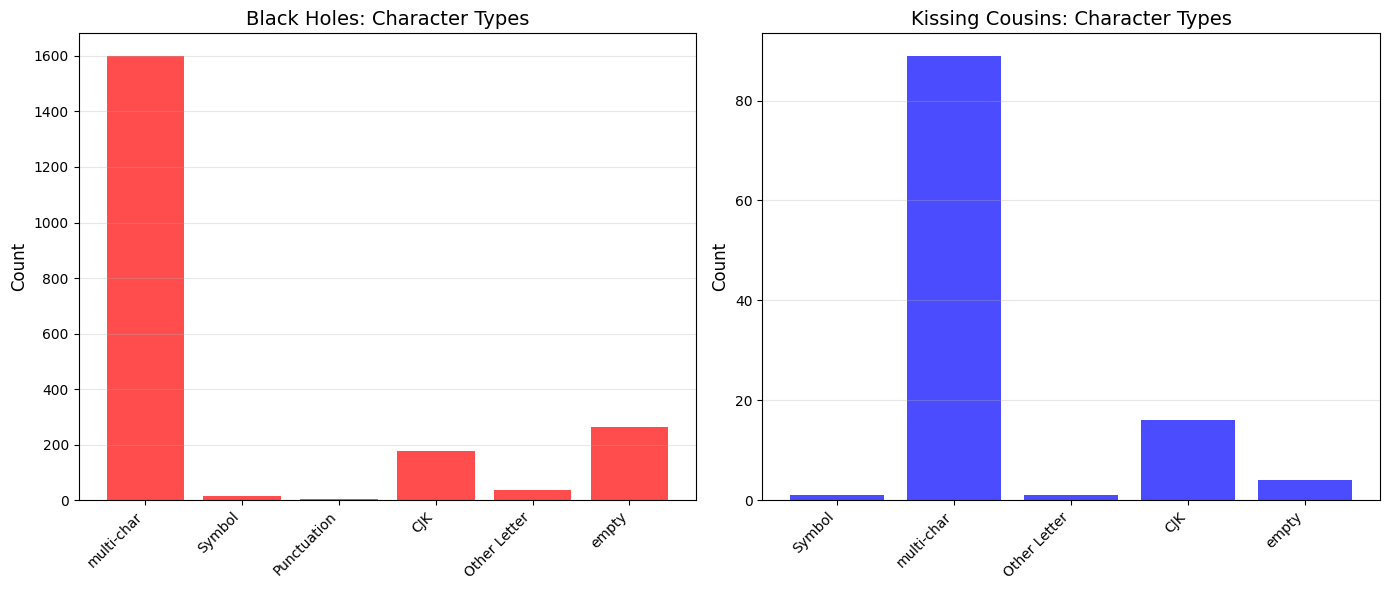

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=100)

# Black holes
types_bh = list(bh_types.keys())
counts_bh = [bh_types[t] for t in types_bh]
ax1.bar(range(len(types_bh)), counts_bh, color='red', alpha=0.7)
ax1.set_xticks(range(len(types_bh)))
ax1.set_xticklabels(types_bh, rotation=45, ha='right')
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Black Holes: Character Types', fontsize=14)
ax1.grid(True, alpha=0.3, axis='y')

# Kissing cousins
types_kc = list(kc_types.keys())
counts_kc = [kc_types[t] for t in types_kc]
ax2.bar(range(len(types_kc)), counts_kc, color='blue', alpha=0.7)
ax2.set_xticks(range(len(types_kc)))
ax2.set_xticklabels(types_kc, rotation=45, ha='right')
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Kissing Cousins: Character Types', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Black Hole Degeneracy Distribution

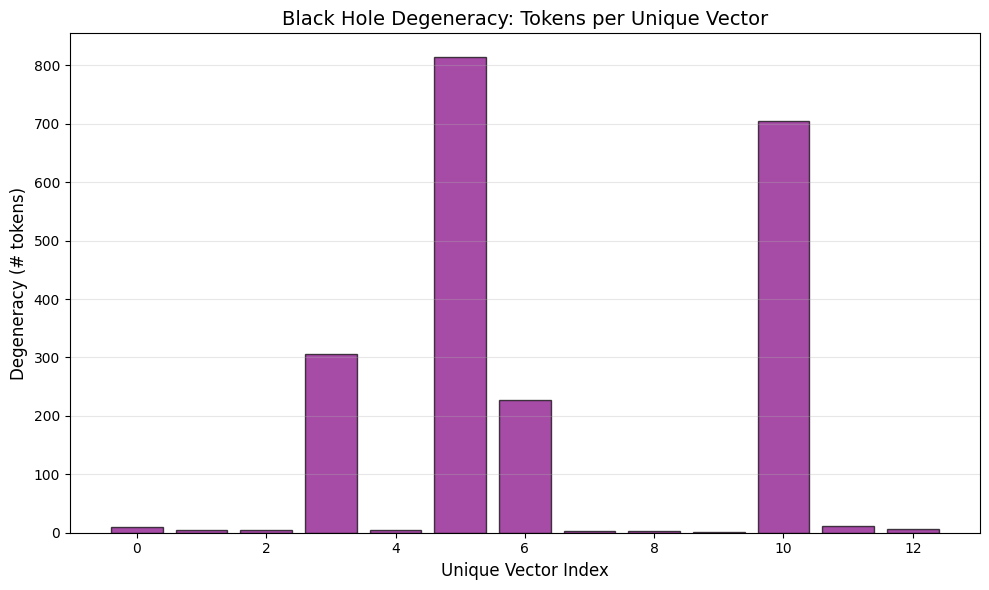

Degeneracy statistics:
  Min:    2 tokens
  Max:    814 tokens
  Mean:   161.5 tokens
  Median: 6 tokens



In [13]:
# Get degeneracy for each unique vector
degeneracies = []
for unique_idx in range(n_unique_bh):
    group_tokens = [t for t in bh_decoded if t['unique_idx'] == unique_idx]
    degeneracies.append(len(group_tokens))

fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

x = list(range(n_unique_bh))
ax.bar(x, degeneracies, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Unique Vector Index', fontsize=12)
ax.set_ylabel('Degeneracy (# tokens)', fontsize=12)
ax.set_title('Black Hole Degeneracy: Tokens per Unique Vector', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Degeneracy statistics:")
print(f"  Min:    {min(degeneracies)} tokens")
print(f"  Max:    {max(degeneracies)} tokens")
print(f"  Mean:   {np.mean(degeneracies):.1f} tokens")
print(f"  Median: {np.median(degeneracies):.0f} tokens")
print()

## Conclusion

**Summary of findings:**

1. **Black holes:** 2,100 tokens collapsed to 13 unique vectors
   - Degeneracy ranges from ? to ? tokens per vector
   - Character type distribution: ?
   
2. **Kissing cousins:** 111 tokens at ~2× ULP separation
   - Character type distribution: ?
   - Hypothesis: 85% Thai? (Let's see!)

3. **Semantic interpretation:**
   - Are these rare/unused tokens?
   - Language-specific collapse (Thai, CJK, etc.)?
   - Training data sparsity?

**Next steps:**
- Search for other degenerate structures in token space
- Investigate training dynamics: why did these specific tokens collapse?
- Check token occurrence frequencies in training data (if available)